In [ ]:
# 用于绘制旭日图，展示组装任务失败技能分布
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
from adjustText import adjust_text
import matplotlib.colors as mcolors

# --------- 定义高对比度颜色生成函数 ---------
def get_distinct_colors(n):
    """生成 n 个高对比度颜色（HSV 均匀分布）"""
    return [mcolors.hsv_to_rgb((i / n, 0.65, 0.95)) for i in range(n)]


# --------- 数据读取 ---------
file_path = "/home/wdy02/Documents/拆卸任务失败技能分布-旭日图-9.7.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# 数据预处理
df['一级分类'] = df['一级分类'].ffill()
df = df.dropna(subset=['二级分类', '数值'])
df = df[df['数值'] > 0]

# 提取二级分类并分配高对比度颜色
sectors = df['二级分类'].unique()
colors_dict = get_distinct_colors(len(sectors))
color_map = {sec: colors_dict[i] for i, sec in enumerate(sectors)}

# 总量
total_sum = df['数值'].sum()

# 一级分类（内圈数据）
inner_data = df.groupby('一级分类')['数值'].sum()
inner_labels = inner_data.index.tolist()
inner_values = inner_data.values
inner_colors = ['#1f77b4', '#ff7f0e']  # Pick/Insert 固定颜色

# --- 绘图 ---
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('equal')

# 内圈（一级分类）
wedges_inner, _ = ax.pie(
    inner_values,
    radius=0.6,
    labels=None,
    startangle=90,
    colors=inner_colors,
    wedgeprops=dict(width=0.3, edgecolor='white')
)

# 内层百分比
wedges_inner, _, autotexts_inner = ax.pie(
    inner_values,
    radius=0.7,
    autopct='%1.1f%%',
    pctdistance=0.55,
    startangle=90,
    colors=inner_colors,
    wedgeprops=dict(width=0.4, edgecolor='white', linewidth=1),
    textprops={'color': 'black', 'fontsize': 12, 'weight': 'bold'}
)

# 添加一级分类文字
for i, (wedge, label) in enumerate(zip(wedges_inner, inner_labels)):
    angle = (wedge.theta1 + wedge.theta2) / 2
    x = 0.4 * np.cos(np.radians(angle)) + 0.03
    y = 0.4 * np.sin(np.radians(angle)) + 0.1
    ax.text(x, y, label, ha='center', va='center',
            fontsize=16, weight='bold', color='black')

# 外圈（二级分类）
outer_wedges = []
for wedge_inner, (cat, inner_val) in zip(wedges_inner, inner_data.items()):
    theta1, theta2 = wedge_inner.theta1, wedge_inner.theta2
    parent_angle = theta2 - theta1

    sub_df = df[df['一级分类'] == cat]  
    sub_values = sub_df['数值'].values
    sub_labels = sub_df['二级分类'].values
    sub_total = sub_values.sum()

    sub_angles = sub_values / sub_total * parent_angle
    start_angle = theta1

    for val, sec, ang in zip(sub_values, sub_labels, sub_angles):
        end_angle = start_angle + ang
        outer = plt.matplotlib.patches.Wedge(
            center=(0, 0),
            r=1.0,
            theta1=start_angle,
            theta2=end_angle,
            width=0.4,
            facecolor=color_map[sec],
            edgecolor="white"
        )
        ax.add_patch(outer)
        outer_wedges.append((outer, val))
        start_angle = end_angle

# ========= 折线引出标注（替换你原来的“外圈百分比文字”块） =========
R_OUT = 1.00   # 外圈半径（与你画 outer wedge 时一致）
R_KNEE = 1.01  # 拐点半径（第一段径向线结束的位置，可微调）
X_TEXT = 1.01  # 文本/引出线终点的 X（右正左负，控制文本离饼图的远近）
MIN_GAP = 0.055  # 同侧相邻标签最小竖向间距（避免重叠，单位是坐标系的 y 距离）
TXT_PAD = 0.015  # 文本与引出线末端的小水平间距

# 先把每个扇区的中角、数值等信息整理出来
items = []
for wedge, value in outer_wedges:
    mid_ang = (wedge.theta1 + wedge.theta2) / 2.0
    ang_rad = np.radians(mid_ang)
    c, s = np.cos(ang_rad), np.sin(ang_rad)

    # 扇区外缘上的起点（略微在外一点更清晰）
    x0 = (R_OUT + 0.01) * c
    y0 = (R_OUT + 0.01) * s

    # 拐点（第一段径向线的终点）
    xk = R_KNEE * c
    yk = R_KNEE * s

    # 文本初始 y（按角度计算到外侧）
    y_text = 1.30 * s   # 只是初值，后面会按侧别做避让

    # 右侧 or 左侧
    side = 1 if c >= 0 else -1

    items.append({
        "angle": mid_ang,
        "x0": x0, "y0": y0,
        "xk": xk, "yk": yk,
        "side": side,
        "y_text": y_text,
        "value": value
    })

# 按左右两侧分别排序并做简单的纵向避让
for side in (1, -1):
    side_items = [it for it in items if it["side"] == side]
    side_items.sort(key=lambda d: d["y_text"])

    for i in range(1, len(side_items)):
        prev = side_items[i-1]
        cur  = side_items[i]
        if cur["y_text"] - prev["y_text"] < MIN_GAP:
            cur["y_text"] = prev["y_text"] + MIN_GAP

# 绘制折线 + 文本
for it in items:
    side = it["side"]
    # 引出线终点（与文本基本在同一竖向）
    xe = side * X_TEXT
    ye = it["y_text"]

    # 第一段：径向短线（扇区外缘 -> 拐点）
    ax.plot([it["x0"], it["xk"]], [it["y0"], it["yk"]], color="black", lw=0.8)
    # 第二段：从拐点到外侧（允许有一定斜率，避免重叠时更自然）
    ax.plot([it["xk"], xe], [it["yk"], ye], color="black", lw=0.8)

    # 文本
    pct = f"{it['value']/total_sum*100:.2f}%"
    label_text = f"{int(it['value'])} ({pct})"
    x_text = xe + (TXT_PAD if side > 0 else -TXT_PAD)
    ha = "left" if side > 0 else "right"

    ax.text(x_text, ye, label_text,
            ha=ha, va="center", fontsize=13, weight="bold", color="black")

# # （可选）让图更紧凑
# plt.tight_layout()


# 图例
legend_elements = [Patch(facecolor=color_map[sec], label=sec) for sec in sectors]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.96, 0.8), loc='upper left', fontsize=14)

# ax.set_title("Disassemble", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()

# 保存高清图像（推荐放在 plt.show() 之前）
plt.savefig('/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_file/useful_scripts/h5_analysis_results/拆卸任务失败技能分布-旭日图.png', 
            dpi=300,                    # 高分辨率
            bbox_inches='tight',        # 去除多余白边
            pad_inches=0.1,             # 适当留白
            transparent=False)          # 背景透明（可选）
plt.show()


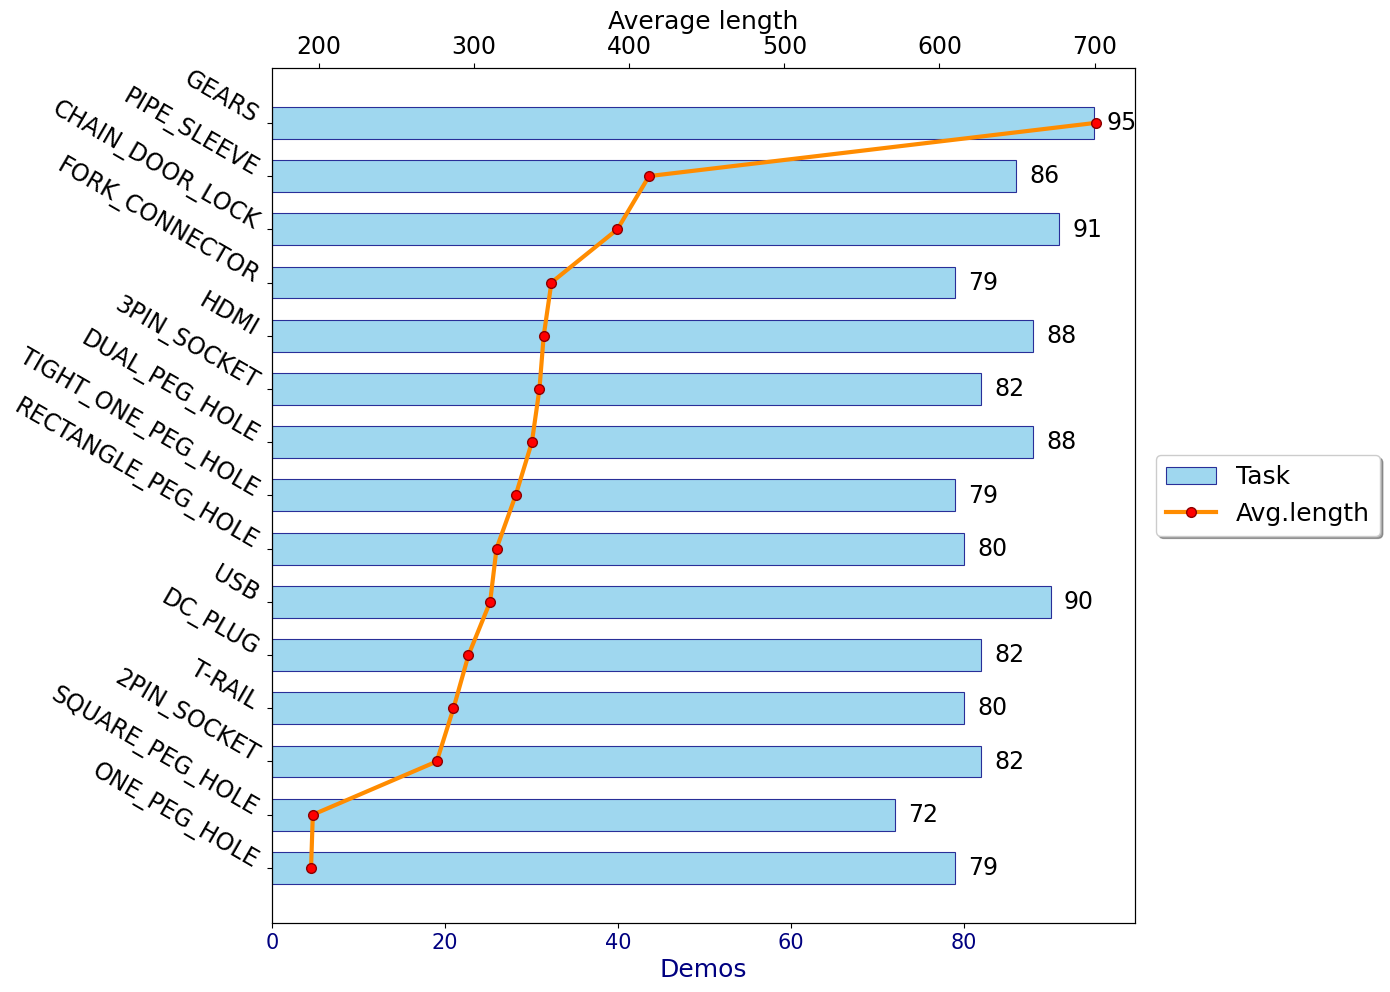

In [19]:
# 用于绘制任务数量和平均时间的程序 
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
file_path = "/home/wdy02/Documents/组装任务成功失败统计-9.7.xlsx"
df = pd.read_excel(file_path)

# 计算总演示数量
df['Total_Demos'] = df['Successful'] + df['Unsuccessful']

# 模拟平均时间（请替换为真实数据）
df['Avg_Time'] = df['Average_steps']

# 创建横向双轴图
fig, ax1 = plt.subplots(figsize=(14, 10))

# 绘制横向柱状图
bars = ax1.barh(df['Name'], df['Total_Demos'], color='skyblue', alpha=0.8, label='Task', edgecolor='navy', linewidth=0.8, height=0.6)

# 在每个柱子上方添加总数量标签
for i, bar in enumerate(bars):
    width = bar.get_width()  # 获取柱子宽度
    ax1.text(width + 1.5, bar.get_y() + bar.get_height()/2,  # x, y 坐标
             f'{int(width)}',  # 显示总数量
             ha='left', va='center',  # 文本对齐方式
             fontsize=17)
    
# 设置主 X 轴
ax1.set_xlabel('Demos', fontsize=18,color='navy')
ax1.tick_params(axis='x', labelcolor='navy', labelsize=15)
ax1.tick_params(axis='y', labelsize=17)

# ✅ 关键修改：倾斜 Y 轴标签（任务名称）
plt.setp(ax1.get_yticklabels(), rotation=-30, ha='right', va='baseline')  # 或 rotation=45
# 创建次 X 轴
ax2 = ax1.twiny()
line = ax2.plot(df['Avg_Time'], df['Name'], color='darkorange', marker='o', linewidth=3, markersize=7, label='Avg.length', markerfacecolor='red', markeredgecolor='darkred')

# 设置次 X 轴
ax2.set_xlabel('Average length', fontsize=18
               ,  color='black')
ax2.tick_params(axis='x', labelcolor='black', labelsize=17)

# 添加标题和图例（关键修改）
# plt.title('Total Demos and Average Demo Length', fontsize=16, fontweight='bold', pad=20)

# 合并图例并精确放置在右侧中间
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 关键修改：将图例放在右侧中间
ax1.legend(lines + lines2, labels + labels2,
           loc='center left',  # 图例的“左中心”对齐到锚点
           bbox_to_anchor=(1.01, 0.5),  # 锚点在右侧中间
           fontsize=18,
           frameon=True,
           fancybox=True,
           shadow=True)

# 优化布局
plt.tight_layout(pad=1.0)

plt.savefig('/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_file/useful_scripts/h5_analysis_results/组装任务数量平均时间统计-柱状图.png', 
            dpi=300,                    # 高分辨率
            bbox_inches='tight',        # 去除多余白边
            pad_inches=0.1,             # 适当留白
            transparent=False)          # 背景透明（可选）

# 显示图表
plt.show()

/tmp/ipykernel_29686/2220698758.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticks(), fontsize=14)
/tmp/ipykernel_29686/2220698758.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticks(), fontsize=14)


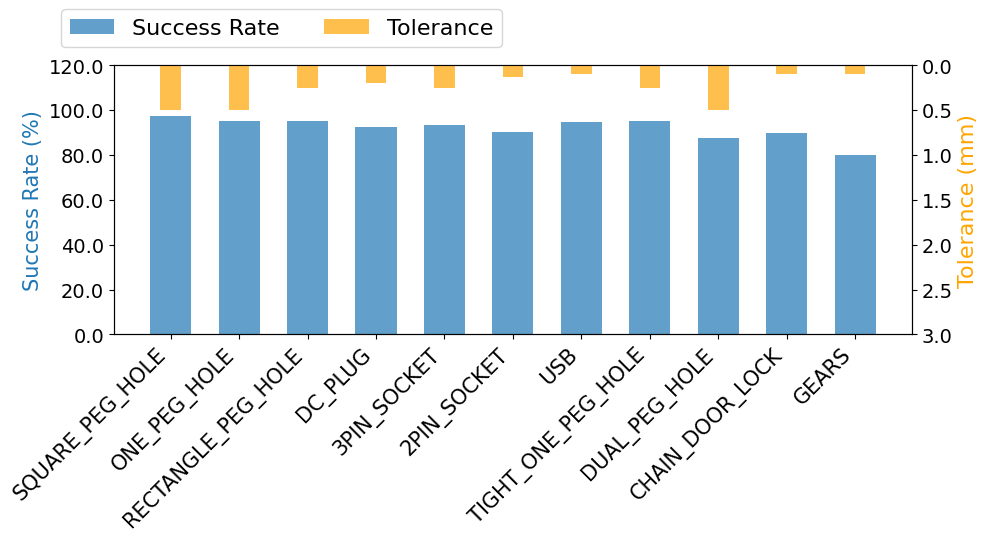

In [29]:
# 绘制每个任务成功率和公差关系-柱状图-误差棒
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
file_path = "/home/wdy02/Documents/拆卸任务成功失败统计-9.7.xlsx"
df = pd.read_excel(file_path)

# 计算成功率
df["Total"] = df["Successful"] + df["Unsuccessful"]
df["SuccessRate"] = df["Successful"] / df["Total"] * 100

# 随机生成公差（2%~10%）
np.random.seed(7)
df["Tolerance"] = df['Interval_1']

x = np.arange(len(df))

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- 左轴：成功率 ---
bars = ax1.bar(x, df["SuccessRate"], width=0.6, color="tab:blue", alpha=0.7, label="Success Rate")
ax1.set_ylabel("Success Rate (%)", color="tab:blue", fontsize=15)
ax1.set_ylim(0, 120)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(df["Name"], rotation=45, ha="right",fontsize=15)

# 标注成功率
# for i, rate in enumerate(df["SuccessRate"]):
#     ax1.text(i, rate + 1, f"{rate:.0f}", ha="center", va="bottom", fontsize=12, color="tab:blue")

# --- 右轴：公差，从顶部往下 ---
ax2 = ax1.twinx()
ax2.set_ylabel("Tolerance (mm)", color="orange", fontsize=16)
ax2.set_ylim( max(df["Tolerance"])*6 , 0 )  # 反转Y轴（从上往下）
ax2.set_yticklabels(ax2.get_yticks(), fontsize=14)

# 绘制公差条
ax2.bar(x, df["Tolerance"], width=0.3, color="orange", alpha=0.7,label= "Tolerance")

# 标注公差
# for i, tol in enumerate(df["Tolerance"]):
#     ax2.text(i, tol + 1, f"{tol}", ha="center", va="top", fontsize=12, color="orange")

# 合并两个图例
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, 
           loc="upper right", bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=16)


# plt.title("Task Success Rate and Tolerance", fontsize=14, fontweight="bold")
plt.tight_layout()

plt.savefig('/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_file/useful_scripts/h5_analysis_results/拆卸任务成功率和公差关系-柱状图.png', 
            dpi=300,                    # 高分辨率
            bbox_inches='tight',        # 去除多余白边
            pad_inches=0.1,             # 适当留白
            transparent=False)          # 背景透明（可选）

plt.show()


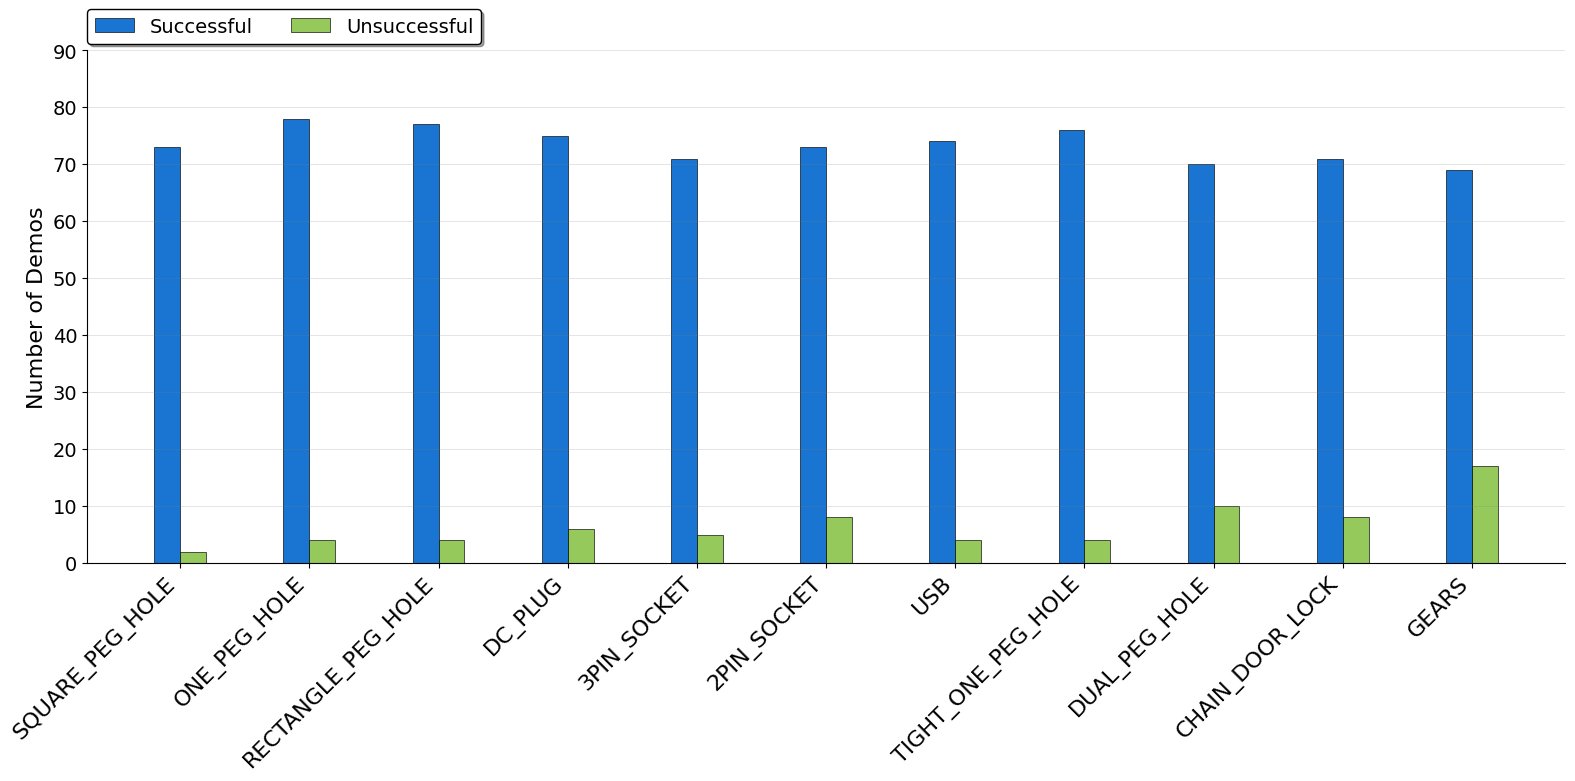

In [8]:
# 绘制各任务成功和失败数量的柱状图

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

def create_task_performance_chart(file_path, saved_path, sheet_name=0):
    """
    读取Excel文件并生成任务性能柱状图
    
    参数:
    file_path: Excel文件路径
    sheet_name: 工作表名称或索引（默认为第一个工作表）
    """

    try:
        # 读取Excel文件
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # 检查必要的列是否存在
        required_columns = ['Name', 'Successful', 'Unsuccessful']
        if not all(col in df.columns for col in required_columns):
            print(f"错误: Excel文件缺少必要列。需要的列: {required_columns}")
            print(f"实际列: {list(df.columns)}")
            return None
        
        # 创建图形
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # 配色方案
        success_color = '#0066cc'  # 深蓝色
        unsuccess_color = '#8bc34a'  # 绿色
        
        # 创建柱状图
        x_positions = np.arange(len(df))
        bar_width = 0.2  # 更窄的柱子宽度
        
        # 绘制成功柱子（左侧）
        bars_success = ax.bar(x_positions - bar_width/2, df['Successful'], 
                             bar_width, color=success_color, edgecolor='black', 
                             linewidth=0.5, alpha=0.9, label='Successful')
        
        # 绘制失败柱子（右侧）
        bars_unsuccess = ax.bar(x_positions + bar_width/2, df['Unsuccessful'], 
                               bar_width, color=unsuccess_color, edgecolor='black', 
                               linewidth=0.5, alpha=0.9, label='Unsuccessful')
        
        # 格式化X轴
        ax.set_xticks(x_positions)
        ax.set_xticklabels(df['Name'], rotation=45, ha='right', fontsize=16)
        
        # 设置标签和标题
        ax.set_ylabel('Number of Demos', fontsize=16)
        file_name = Path(file_path).stem
        # ax.set_title(f'Assemble', 
        #             fontsize=16, fontweight='bold', pad=20)
        
        # Y轴设置
        max_y = max(df['Successful'].max(), df['Unsuccessful'].max()) + 5
        y_max = max(90, max_y)  # 至少显示到80
        ax.set_ylim(0, y_max)
        ax.set_yticks(range(0, y_max + 1, 10))
        ax.set_yticklabels([str(i) for i in range(0, y_max + 1, 10)], fontsize=14)
        
        # 网格线
        ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='gray')
        
        # 图例 - 放在左上方，水平排列
        legend = ax.legend(loc='upper left', frameon=True, fancybox=True, 
                        shadow=True, fontsize=14, ncol=2, 
                        bbox_to_anchor=(0, 1.08),  # 将图例向上移动
                        borderaxespad=0.)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')
        
        # 去除顶部和右侧边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 调整布局
        plt.tight_layout()
        # 保存图片
        plt.savefig(saved_path, 
                    dpi=300,                    # 高分辨率
                    bbox_inches='tight',        # 去除多余白边
                    pad_inches=0.1,             # 适当留白
                    transparent=False)          # 背景透明（可选）

        plt.show()
        
        
    except Exception as e:
        print(f"读取文件时出错: {e}")
        return None

def create_stacked_bars_chart(file_path, sheet_name=0):
    """
    创建堆叠柱状图（如第二个示例所示）
    """
    
    try:
        # 读取Excel文件
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # 检查必要的列是否存在
        required_columns = ['Name', 'Successful', 'Unsuccessful']
        if not all(col in df.columns for col in required_columns):
            print(f"错误: Excel文件缺少必要列。需要的列: {required_columns}")
            print(f"实际列: {list(df.columns)}")
            return None
            
        # 设置中文字体支持
        plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans', 'Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False
        
        # 创建图形
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # 配色方案
        success_color = '#0066cc'  # 深蓝色
        unsuccess_color = '#8bc34a'  # 绿色
        
        # 创建堆叠柱状图
        x_positions = np.arange(len(df))
        bar_width = 0.8
        
        # 绘制成功柱子（底部）
        bars_success = ax.bar(x_positions, df['Successful'], bar_width, 
                             color=success_color, edgecolor='black', linewidth=0.5,
                             alpha=0.9, label='Successful')
        
        # 绘制失败柱子（堆叠在成功之上）
        bars_unsuccess = ax.bar(x_positions, df['Unsuccessful'], bar_width, 
                               bottom=df['Successful'], color=unsuccess_color, 
                               edgecolor='black', linewidth=0.5, alpha=0.9,
                               label='Unsuccessful')
        
        # 格式化X轴
        ax.set_xticks(x_positions)
        ax.set_xticklabels(df['Name'], rotation=45, ha='right', fontsize=10, 
                          fontweight='bold')
        
        # 设置标签和标题
        ax.set_ylabel('Number of Attempts', fontsize=12, fontweight='bold')
        file_name = Path(file_path).stem
        ax.set_title(f'Task Number Analysis', 
                    fontsize=14, fontweight='bold', pad=20)
        
        # Y轴设置
        max_y = (df['Successful'] + df['Unsuccessful']).max() + 5
        y_max = max(90, max_y)  # 至少显示到90
        ax.set_ylim(0, y_max)
        ax.set_yticks(range(0, y_max + 1, 10))
        ax.set_yticklabels([str(i) for i in range(0, y_max + 1, 10)], fontsize=10)
        
        # 网格线
        ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5, color='gray')
        
        # 图例 - 放在右上方，水平排列
        legend = ax.legend(loc='upper right', frameon=True, fancybox=True, 
                          shadow=True, fontsize=10, ncol=2)  # ncol=2表示两列
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')
        
        # 去除顶部和右侧边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 调整布局
        plt.tight_layout()
        # 保存图片
        plt.savefig('/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_file/useful_scripts/h5_analysis_results//组装任务成功和失败数量-柱状图.png', 
                    dpi=300,                    # 高分辨率
                    bbox_inches='tight',        # 去除多余白边
                    pad_inches=0.1,             # 适当留白
                    transparent=False)          # 背景透明（可选）

        plt.show()
        
    except Exception as e:
        print(f"读取文件时出错: {e}")
        return None
    
# 使用示例
if __name__ == "__main__":
    file_path = "/home/wdy02/Documents/拆卸任务成功失败统计-9.7.xlsx"
    saved_path = "/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_file/useful_scripts/h5_analysis_results/拆卸任务成功和失败数量-柱状图.png"
    create_task_performance_chart(file_path,saved_path)


/tmp/ipykernel_30386/1338823273.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # 为 colorbar 留出空间


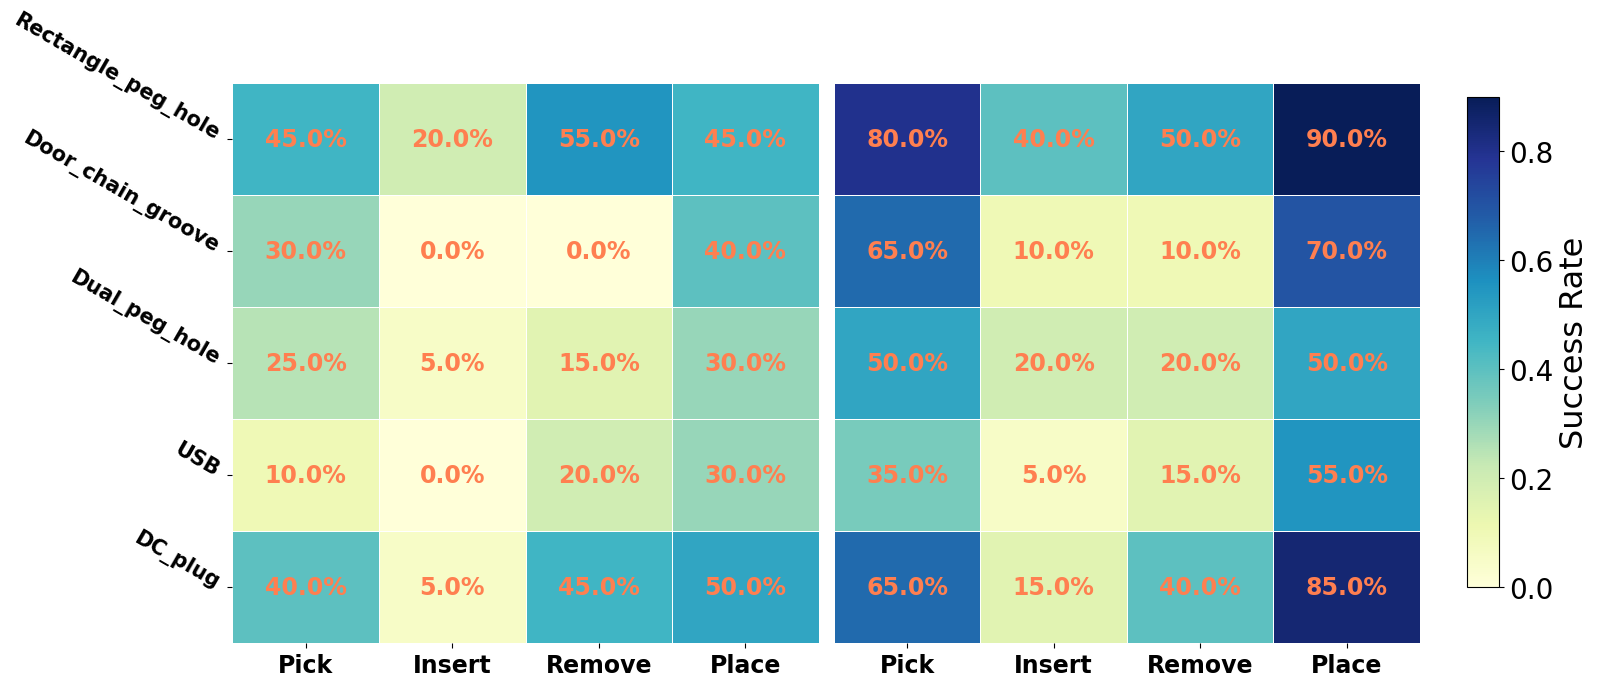

In [5]:
# 实验中，BC 和 IQL 任务技能成功率的热力图。
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# 1. 读取 Excel 数据
# =========================
file_path = "/home/wdy02/Documents/BC_IQL实验结果-9.12.xlsx"
sheets = ["BC", "IQL"]

data_dict = {}
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet, index_col=0)
    data_dict[sheet] = df

TOTAL = 20
for sheet in sheets:
    data_dict[sheet] = data_dict[sheet] / TOTAL  # 转为比例

# =========================
# 2. 设置绘图参数
# =========================

# 获取统一颜色范围
all_data = np.concatenate([
    data_dict["BC"].values.flatten(),
    data_dict["IQL"].values.flatten()
])
vmin, vmax = all_data.min(), all_data.max()

# === 绘图 ===
fig = plt.figure(figsize=(16, 7))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# 第一个热力图（BC）
sns.heatmap(data_dict["BC"], annot=True, fmt=".1%", cmap="YlGnBu", cbar=False,
            linewidths=0.5, annot_kws={'size': 17, 'weight': 'bold','color': 'coral'}, ax=ax1, vmin=vmin, vmax=vmax)
# ax1.set_title("BC Task Results - Heatmap", fontsize=14, pad=20)
ax1.set_ylabel('')
# ax1.set_xlabel('Stage', fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=-30, ha='right', va='baseline',fontsize=15,weight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=17,weight='bold')

# 第二个热力图（IQL）
sns.heatmap(data_dict["IQL"], annot=True, fmt=".1%", cmap="YlGnBu", cbar=False,
            linewidths=0.5, annot_kws={'size': 17, 'weight': 'bold','color': 'coral'}, ax=ax2, vmin=vmin, vmax=vmax)
# ax2.set_title("IQL Task Results - Heatmap", fontsize=14, pad=20)
ax2.set_ylabel('')
# ax2.set_xlabel('Stage', fontsize=12)
ax2.set_yticklabels([])
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=17,weight='bold')
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)  # 隐藏 y 轴

# === 共享 colorbar ===
mappable = ax1.collections[0]
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(mappable, cax=cbar_ax, label='Success Rate')
cbar_ax.yaxis.label.set_fontsize(23)
# 设置刻度标签字体大小
cbar_ax.tick_params(labelsize=20)

# === 布局调整 ===
plt.tight_layout(rect=[0, 0, 0.9, 1])  # 为 colorbar 留出空间
plt.savefig('/home/wdy02/wdy_program/simulation_plus/IsaacLab/InduMan/useful_scripts/h5_analysis_results/BC_IQL_shared_colorbar_no_right_labels.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

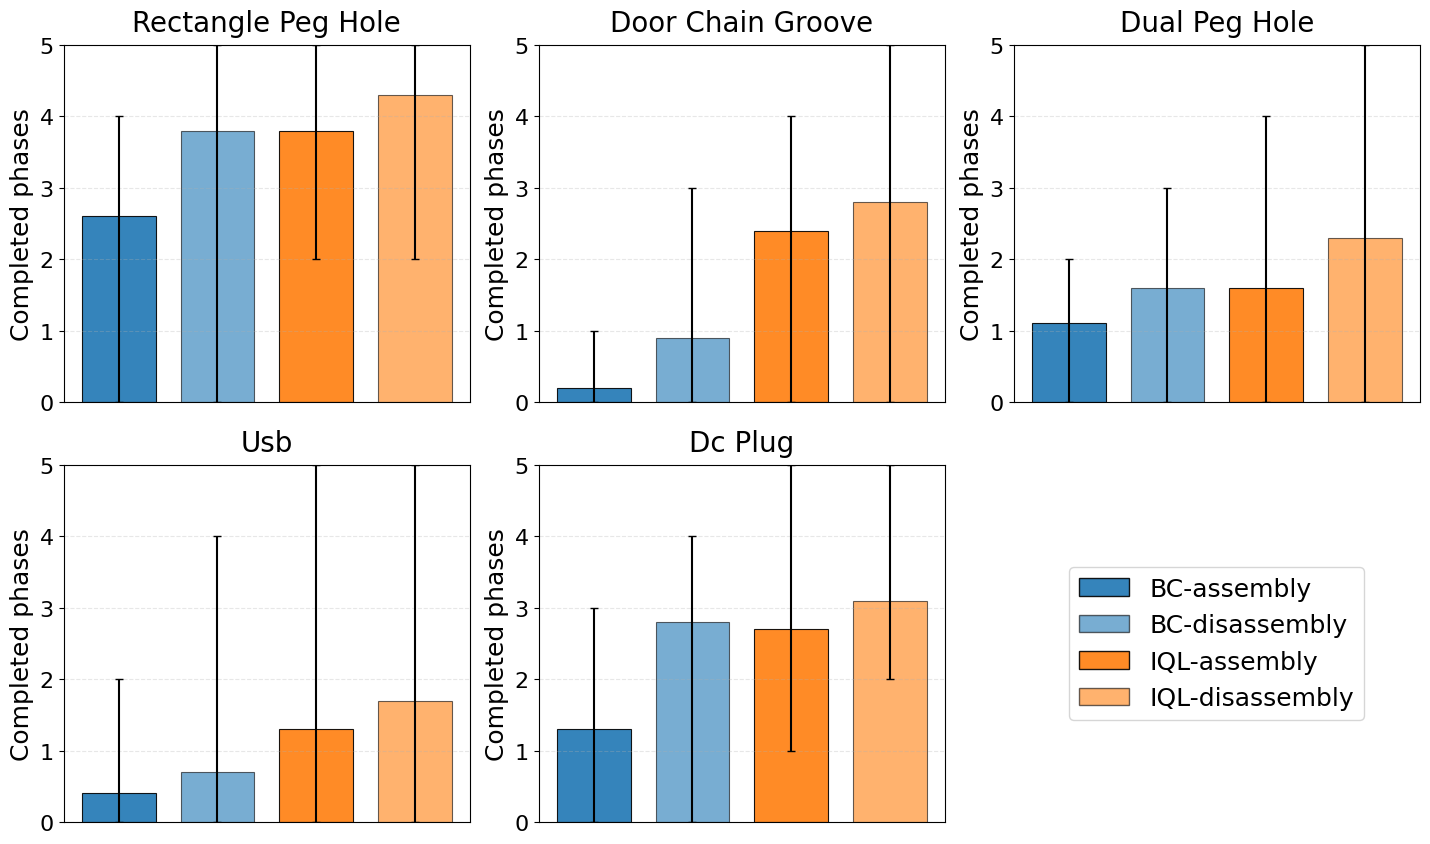

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----------------------------
# 读取数据
# ----------------------------
excel_file = "/home/wdy02/Documents/BC_IQL实验结果-分阶段.xlsx"

# 定义 sheet 名称及其对应算法
sheet_config = {
    'BC-assembly': {'algo': 'BC', 'env': 'assembly'},
    'BC-disassembly': {'algo': 'BC', 'env': 'disassembly'},
    'IQL-assembly': {'algo': 'IQL', 'env': 'assembly'},
    'IQL-disassembly': {'algo': 'IQL', 'env': 'disassembly'}
}

# 读取所有 sheet
data_dfs = {}
for sheet_name in sheet_config:
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    df.columns = ['Tasks', 'means', 'min', 'max']
    data_dfs[sheet_name] = df

# 获取任务列表
tasks = data_dfs['BC-assembly']['Tasks'].tolist()

# 创建 2x3 子图
fig, axes = plt.subplots(2, 3, figsize=(16, 9), dpi=100)
axes = axes.flatten()

# 颜色映射
colors = {'BC': 'tab:blue', 'IQL': 'tab:orange'}

# x 位置（为 4 个柱子预留）
x_pos = np.array([0, 0.2, 0.4, 0.6])
width = 0.15  # 更宽一些更清晰

# 绘制每个任务
for i, task in enumerate(tasks):
    ax = axes[i]

    # 存储绘图数据
    plot_data = []

    for sheet_name, config in sheet_config.items():
        df = data_dfs[sheet_name]
        row = df[df['Tasks'] == task]
        if row.empty:
            continue
        mean_val = row['means'].values[0]
        min_val = row['min'].values[0]
        max_val = row['max'].values[0]

        lower_err = mean_val - min_val
        upper_err = max_val - mean_val
        yerr_array = np.array([[lower_err], [upper_err]])

        algo = config['algo']
        env = config['env']
        color = colors[algo]
        alpha = 0.9 if env == 'assembly' else 0.6
        label = f"{algo}-{env}"

        plot_data.append({
            'mean': mean_val,
            'yerr': yerr_array,
            'color': color,
            'alpha': alpha,
            'label': label
        })

    # 逐个绘制柱状图（避免 alpha list 报错）
    for j, data in enumerate(plot_data):
        ax.bar(x_pos[j], data['mean'], width=width,
               color=data['color'], alpha=data['alpha'],
               yerr=data['yerr'], capsize=3,
               edgecolor='black', linewidth=0.8,
               label=data['label'] if i == 0 else "")  # 只在第一个子图加 label 用于图例

    ax.set_title(task.replace('_', ' ').title(), fontsize=20, pad=10)
    ax.set_ylabel('Completed phases', fontsize=18)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, 5)
    ax.tick_params(axis='y', labelsize=16)

# ----------------------------
# 第 6 个子图：图例
# ----------------------------
last_ax = axes[5]
last_ax.axis('off')

# 手动创建图例（使用唯一标签）
handles = []
labels = []

# 使用集合去重
added = set()
for sheet_name, config in sheet_config.items():
    algo = config['algo']
    env = config['env']
    label = f"{algo}-{env}"
    color = colors[algo]
    alpha = 0.9 if env == 'assembly' else 0.6

    if label not in added:
        handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=alpha, edgecolor='black'))
        labels.append(label)
        added.add(label)

# 添加图例
last_ax.legend(handles, labels, loc='center', fontsize=18, frameon=True, fancybox=True, shadow=False, ncol=1)

# 可选：设置背景框
last_ax.set_xlim(0, 1)
last_ax.set_ylim(0, 1)
last_ax.set_aspect('equal')

# 调整布局
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 留空间给图例

# 保存图像（路径根据需要修改）
plt.savefig("/home/wdy02/wdy_program/simulation_plus/IsaacLab/wdy_file/useful_scripts/h5_analysis_results/BC_vs_IQL_all_scenarios.png",
            dpi=300, bbox_inches='tight')

plt.show()